In [1]:
import sys
import torch
import global_variables as gv
import sys
import numpy as np
import matplotlib.pyplot as plt
import configparser
from FACTS_Modules.Model import model_factory
from FACTS_Modules.util import string2dtype_array
from FACTS_Modules.TADA import MakeGestScore
from facts_visualizations import single_trial_plots, multi_trial_plots
import os 
import pdb
import seaborn as sns

In [2]:
def FACTS(theta):
    ini='DesignC_AUKF_onlinepertdelay_SBI.ini'
    gFile='GesturalScores/KimetalOnlinepert2.G'
    config = configparser.ConfigParser()
    config.read(ini)

    # Replace the parameter value from ini file
    #pdb.set_trace()
    try:
        if theta.dim() > 1:
            config['SensoryNoise']['Auditory_sensor_scale'] = str(theta[0][0].item())
            config['SensoryNoise']['Somato_sensor_scale'] = str(theta[0][1].item())
            
            config['TaskStateEstimator']['process_scale'] = str(theta[0][2].item())
            config['TaskStateEstimator']['covariance_scale'] = str(theta[0][3].item())
            config['ArticStateEstimator']['process_scale'] = str(theta[0][4].item())
            config['ArticStateEstimator']['covariance_scale'] = str(theta[0][5].item())

            config['SensoryDelay']['Auditory_delay'] = str(theta[0][6].item())
            config['SensoryDelay']['Somato_delay'] = str(theta[0][7].item())
            config['TaskStateEstimator']['cc_discount_from_delay'] = str(theta[0][8].item())
            
#             config['TaskStateEstimator']['estimated_auditory_delay'] = str(theta[0][6].item())
#             config['ArticStateEstimator']['estimated_somat_delay'] = str(theta[0][7].item())
            
        else:
            #pdb.set_trace()
            config['SensoryNoise']['Auditory_sensor_scale'] = str(theta[0].item())
            config['SensoryNoise']['Somato_sensor_scale'] = str(theta[1].item())
            
            config['TaskStateEstimator']['process_scale'] = str(theta[2].item())
            config['TaskStateEstimator']['covariance_scale'] = str(theta[3].item())
            config['ArticStateEstimator']['process_scale'] = str(theta[4].item())
            config['ArticStateEstimator']['covariance_scale'] = str(theta[5].item())

            config['SensoryDelay']['Auditory_delay'] = str(theta[6].item())
            config['SensoryDelay']['Somato_delay'] = str(theta[7].item())
            config['TaskStateEstimator']['cc_discount_from_delay'] = str(theta[8].item())

        # Note from Alvince, need to pass this in   
        config['TaskStateEstimator']['Auditory_delay']  = config['SensoryDelay']['Auditory_delay'] 
        config['ArticStateEstimator']['Somato_delay']  = config['SensoryDelay']['Somato_delay'] 
    except:
        pdb.set_trace()

    model = model_factory(config)
    #pdb.set_trace()
    if 'MultTrials' in config.sections(): 
        ntrials = int(config['MultTrials']['ntrials'])
        target_noise= float(config['MultTrials']['Target_noise'])
    else: 
        ntrials = 1
        target_noise = 0

    #pdb.set_trace()
    gest_name = gFile.split('/')[-1].split('/')[-1]
    np.random.seed(100)
    GestScore, ART, ms_frm, last_frm = MakeGestScore(gFile,target_noise)
    
    # initialize vectors to monitor position at each timestep
    buffer_size = int(float(config['SensoryDelay']['Auditory_delay']) / 5)  # default used to be 20
    x_tilde_delaywindow = np.full([buffer_size,gv.x_dim*2], np.nan) #a new variable that state estimators will have a partial access to
    a_tilde_delaywindow = np.full([buffer_size,gv.a_dim*2], np.nan) #a new variable that state estimators will have a partial access to


    x_tilde_record = np.full([last_frm+buffer_size,gv.x_dim*2], np.nan) #changed
    somato_record = np.full([last_frm+buffer_size,gv.a_dim*2], np.nan) #changed
    formant_record = np.full([last_frm+buffer_size,3], np.nan) #changed
    a_tilde_record = np.full([last_frm+buffer_size,gv.a_dim*2], np.nan) #changed
    formants_produced_record = np.full([last_frm,3], np.nan)

    x_tilde_record_alltrials = np.empty([ntrials,last_frm+buffer_size,gv.x_dim]) #changed
    somato_record_alltrials = np.full([ntrials,last_frm+buffer_size,gv.a_dim*2], np.nan) #changed
    formant_record_alltrials = np.full([ntrials,last_frm+buffer_size,3], np.nan) #changed
    shift_record_alltrials = np.full([ntrials,last_frm+buffer_size,3], np.nan) #changed
    formants_produced_record_alltrials = np.full([ntrials,last_frm,3], np.nan)

    
    a_tilde_record_alltrials = np.empty([ntrials,last_frm+buffer_size,gv.a_dim])
    a_dot_record_alltrials = np.empty([ntrials,last_frm+buffer_size,gv.a_dim])
    a_dotdot_record_alltrials = np.empty([ntrials,last_frm+buffer_size,gv.a_dim])
    predict_formant_record_alltrials = np.empty([ntrials,last_frm+buffer_size,3])

    pdb.set_trace()
    #Check if catch trials (no perturbation) are specified in the config file
    if 'CatchTrials' in config.keys():
        catch_trials = string2dtype_array(config['CatchTrials']['catch_trials'], dtype='int')
        catch_types = string2dtype_array(config['CatchTrials']['catch_types'], dtype='int')
        if len(catch_trials) != len(catch_types):
            raise Exception("Catch trial and catch type lengths not matching, please check the config file.")
    else: catch_trials = np.array([])

    #Run FACTS for each trial
    for trial in range(ntrials):
        #print("trial:", trial)
        #Gestural score (task)
        GestScore, ART, ms_frm, last_frm = MakeGestScore(gFile,target_noise)         #this is similar with MakeGest in the matlab version

        # initial condition
        x_tilde_delaywindow[0] = string2dtype_array(config['InitialCondition']['x_tilde_init'],'float')
        a_tilde_delaywindow[0] = string2dtype_array(config['InitialCondition']['a_tilde_init'],'float')
        x_tilde_record[0] = string2dtype_array(config['InitialCondition']['x_tilde_init'],'float')
        a_tilde_record[0] = string2dtype_array(config['InitialCondition']['a_tilde_init'],'float')
        a_actual = string2dtype_array(config['InitialCondition']['a_tilde_init'],'float')
        model.artic_sfc_law.reset_prejb() #save the initial artic-to-task model.

        if trial in catch_trials: catch = catch_types[np.where(catch_trials==trial)[0][0]]
        else: catch = False
        #print("catch:", catch)
        
        for i_frm in range(last_frm): #gotta change this hardcoded number to aud delay later
            #model function runs FACTS by each frame
            x_tilde_delaywindow, a_tilde_delaywindow, a_actual, somato_record, formant_record, adotdot, y_hat, formants_produced = model.run_one_timestep(x_tilde_delaywindow, a_tilde_delaywindow, a_actual, somato_record, formant_record, GestScore, ART, ms_frm, i_frm, trial, catch)
            if (formants_produced == -1).all():
                formants_produced_record[i_frm:] = [-1, -1, -1]
                a_tilde_record[i_frm:] = np.tile(-10000, 12)
                x_tilde_record[i_frm:] = np.tile(-10000, 14)
                break
            else:
                a_tilde_record[i_frm+1] = a_tilde_delaywindow[0,:] #0 is always the most recnet current frame
                x_tilde_record[i_frm+1] = x_tilde_delaywindow[0,:] #0 is always the most recnet current frame
                formants_produced_record[i_frm] = formants_produced 
            
        
        predict_formant_record_alltrials[trial,] = y_hat
        formants_produced_record_alltrials[trial,] = formants_produced_record
        
        a_tilde_record_alltrials[trial,] = a_tilde_record[:,0:gv.a_dim]
        #a_dot_record[trial, ] = a_tilde[gv.a_dim:]
        x_tilde_record_alltrials[trial,] = x_tilde_record[:,0:gv.x_dim]
        formant_record_alltrials[trial,] = formant_record
        somato_record_alltrials[trial,] = somato_record
        
        model.task_state_estimator.update(catch)
        
        del x_tilde_record
        del a_tilde_record
        del formant_record
        del somato_record
#     pdb.set_trace()
    return formants_produced_record_alltrials[:,:,0].squeeze() 



self.Aud_delay 17
> /var/folders/7n/wgjmy2fx5dd5gczm516m_tdm0000gn/T/ipykernel_97871/34196940.py(87)FACTS()
     85     pdb.set_trace()
     86     #Check if catch trials (no perturbation) are specified in the config file
---> 87     if 'CatchTrials' in config.keys():
     88         catch_trials = string2dtype_array(config['CatchTrials']['catch_trials'], dtype='int')
     89         catch_types = string2dtype_array(config['CatchTrials']['catch_types'], dtype='int')

ipdb> c


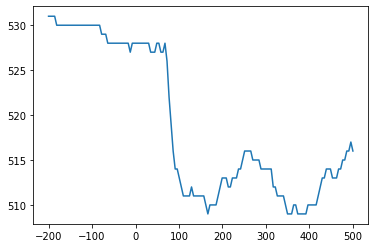

In [4]:
original_theta = torch.from_numpy(np.array([0.005, 0.005, 0.01, 0.1, 0.0000001, 0.0000001, 85, 75, 3]))
# test_theta = torch.from_numpy(np.array([0.0188, 0.05, 2.4, 2.6, 0.0000001, 0.0000001, 100, 50, 4]))

simulated_test = FACTS(original_theta)
x_time = np.linspace(-200,500, num=150)
plt.plot(x_time, simulated_test)